In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import sys
sys.path.append('../')
import KMeans
%matplotlib inline
DIR_DATASET = "../data_set/"

In [2]:
filename = "N-CMAPSS_DS07.h5"

In [3]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (7219962, 4)
X_s shape: (7219962, 14)
X_v shape: (7219962, 14)
T shape: (7219962, 10)
A shape: (7219962, 4)


In [4]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


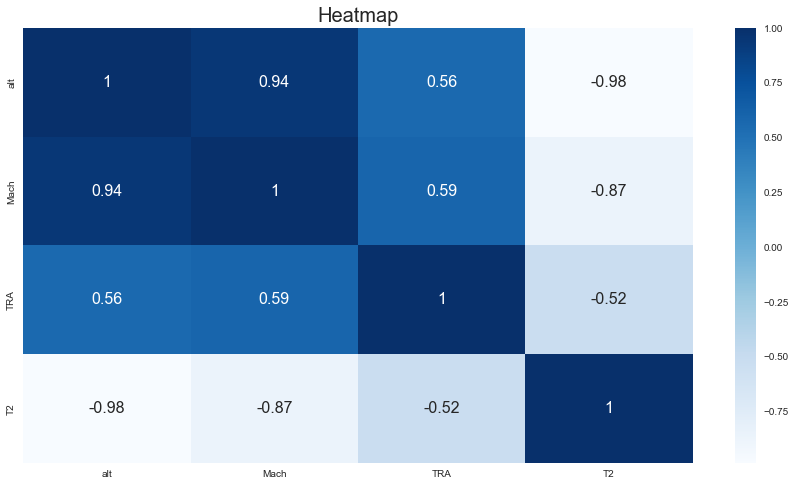

In [5]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [6]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
0,628.042667,1511.321539,1926.531777,1305.716844,20.030600,14.445617,20.335634,25.652134,433.667246,440.413903,16.508168,2240.817076,8822.151341,5.280492,1.0,3002.0,0.370377,81.122467,521.900827
1,628.030676,1511.266957,1926.545472,1305.729983,20.027941,14.444604,20.332935,25.648438,433.581419,440.325438,16.504423,2240.682993,8821.934705,5.279754,1.0,3010.0,0.370818,81.122467,521.904702
2,628.037901,1511.256216,1926.497756,1305.662340,20.027044,14.444141,20.332025,25.647647,433.541962,440.285902,16.501093,2240.711260,8821.904115,5.279080,1.0,3017.0,0.371259,81.122467,521.912580
3,628.049963,1511.249074,1926.457422,1305.580575,20.025528,14.443352,20.330486,25.646253,433.485825,440.229389,16.495964,2240.760174,8821.882308,5.278224,1.0,3030.0,0.372078,81.122467,521.926210
4,628.053010,1511.208545,1926.360048,1305.474914,20.023754,14.442366,20.328685,25.644478,433.409814,440.153048,16.491161,2240.761581,8821.756077,5.276998,1.0,3038.0,0.372519,81.122467,521.930527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7219957,566.459593,1258.643737,1497.397109,1137.314974,16.047061,13.748366,16.291432,18.353409,223.357349,227.987269,14.232466,1591.927196,7975.777436,2.140171,10.0,3018.0,0.258741,26.367001,514.708718
7219958,566.497803,1258.704446,1497.462049,1137.351624,16.051913,13.752884,16.296358,18.359057,223.412506,228.043709,14.235118,1591.978677,7975.971226,2.140743,10.0,3013.0,0.259182,26.367001,514.748340
7219959,566.470161,1258.685975,1497.360571,1137.300341,16.049388,13.749745,16.293795,18.356251,223.405834,228.037402,14.236747,1591.998128,7975.952634,2.140410,10.0,3009.0,0.258111,26.367001,514.707340
7219960,566.514360,1258.753800,1497.570601,1137.449455,16.055003,13.755381,16.299496,18.362443,223.464416,228.096246,14.238965,1591.981083,7976.122915,2.141432,10.0,3006.0,0.258930,26.367001,514.762020


In [7]:
df_X_s.describe()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
count,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06,7.219962e+06
mean,5.690619e+02,1.330366e+03,1.637701e+03,1.128526e+03,1.290414e+01,1.007082e+01,1.310065e+01,1.589904e+01,2.363508e+02,2.405684e+02,1.007363e+01,1.956703e+03,8.238071e+03,2.533170e+00,5.453904e+00,1.572505e+04,5.365834e-01,6.048590e+01,4.898873e+02
std,2.122127e+01,6.821212e+01,1.233722e+02,6.270418e+01,2.902209e+00,2.438112e+00,2.946405e+00,3.468292e+00,5.913336e+01,5.997372e+01,2.771161e+00,1.864933e+02,2.263086e+02,7.846359e-01,2.943511e+00,8.158280e+03,1.213336e-01,1.835228e+01,2.008431e+01
min,4.842350e+02,1.072524e+03,9.544701e+02,6.983521e+02,5.917805e+00,4.373175e+00,6.007923e+00,6.915483e+00,8.080261e+01,8.250571e+01,4.130507e+00,1.470141e+03,7.365904e+03,3.373145e-01,1.000000e+00,3.001000e+03,3.150000e-04,2.355452e+01,4.213779e+02
25%,5.536977e+02,1.284842e+03,1.553818e+03,1.084458e+03,1.035018e+01,7.843126e+00,1.050780e+01,1.299146e+01,1.913856e+02,1.949678e+02,7.527209e+00,1.840798e+03,8.087540e+03,1.971531e+00,2.000000e+00,9.095000e+03,4.425120e-01,4.684537e+01,4.729682e+02
50%,5.668656e+02,1.325781e+03,1.646860e+03,1.118685e+03,1.316495e+01,1.039391e+01,1.336543e+01,1.597297e+01,2.240003e+02,2.282716e+02,1.025027e+01,2.000972e+03,8.229044e+03,2.324090e+00,6.000000e+00,1.425500e+04,5.435640e-01,6.407181e+01,4.944232e+02
75%,5.830177e+02,1.369605e+03,1.710960e+03,1.163907e+03,1.521078e+01,1.199507e+01,1.544241e+01,1.837183e+01,2.706289e+02,2.754307e+02,1.220361e+01,2.113350e+03,8.371328e+03,2.929673e+00,9.000000e+00,2.299300e+04,6.390720e-01,7.716742e+01,5.065986e+02
max,6.342083e+02,1.527196e+03,1.985811e+03,1.374802e+03,2.044905e+01,1.568410e+01,2.076045e+01,2.644091e+01,4.492520e+02,4.557423e+02,1.677457e+01,2.285550e+03,8.871119e+03,5.649010e+00,1.000000e+01,3.503300e+04,7.492590e-01,8.876890e+01,5.343834e+02


-2.2172724144124984e-16 1.0000000000000018
(7219962, 18)


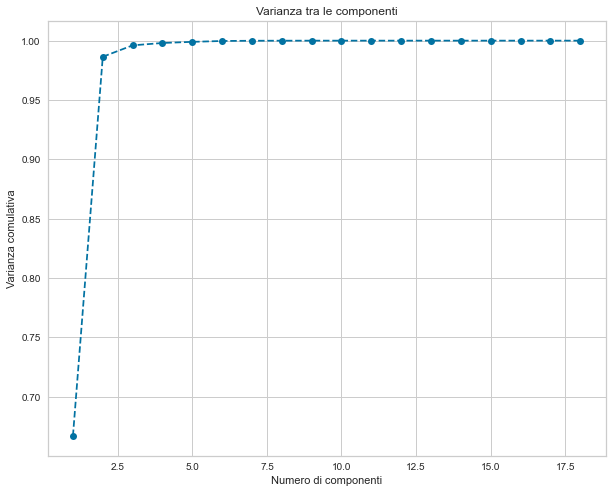

In [8]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit"]))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 3


KMeans(n_clusters=3, random_state=42)

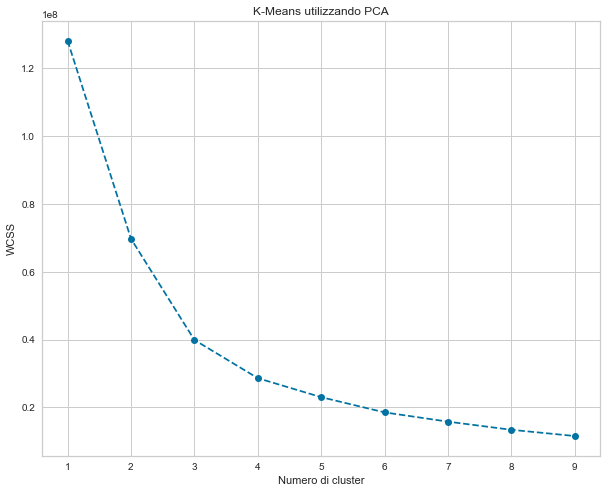

In [9]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
     kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
     kmeans_pca.fit(scores_pca)
     wcss.append(kmeans_pca.inertia_)
     print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

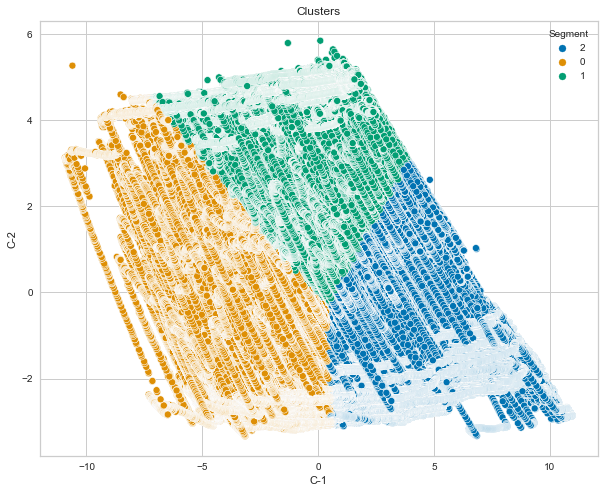

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,unit,alt,Mach,TRA,T2,C-1,C-2,Segm K-means PCA,Segment
0,628.042667,1511.321539,1926.531777,1305.716844,20.030600,14.445617,20.335634,25.652134,433.667246,440.413903,...,5.280492,1.0,3002.0,0.370377,81.122467,521.900827,10.124057,-2.269444,2,2
1,628.030676,1511.266957,1926.545472,1305.729983,20.027941,14.444604,20.332935,25.648438,433.581419,440.325438,...,5.279754,1.0,3010.0,0.370818,81.122467,521.904702,10.120330,-2.270126,2,2
2,628.037901,1511.256216,1926.497756,1305.662340,20.027044,14.444141,20.332025,25.647647,433.541962,440.285902,...,5.279080,1.0,3017.0,0.371259,81.122467,521.912580,10.118007,-2.271047,2,2
3,628.049963,1511.249074,1926.457422,1305.580575,20.025528,14.443352,20.330486,25.646253,433.485825,440.229389,...,5.278224,1.0,3030.0,0.372078,81.122467,521.926210,10.114420,-2.273128,2,2
4,628.053010,1511.208545,1926.360048,1305.474914,20.023754,14.442366,20.328685,25.644478,433.409814,440.153048,...,5.276998,1.0,3038.0,0.372519,81.122467,521.930527,10.110584,-2.273610,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7219957,566.459593,1258.643737,1497.397109,1137.314974,16.047061,13.748366,16.291432,18.353409,223.357349,227.987269,...,2.140171,10.0,3018.0,0.258741,26.367001,514.708718,1.558422,4.954317,1,1
7219958,566.497803,1258.704446,1497.462049,1137.351624,16.051913,13.752884,16.296358,18.359057,223.412506,228.043709,...,2.140743,10.0,3013.0,0.259182,26.367001,514.748340,1.562217,4.953874,1,1
7219959,566.470161,1258.685975,1497.360571,1137.300341,16.049388,13.749745,16.293795,18.356251,223.405834,228.037402,...,2.140410,10.0,3009.0,0.258111,26.367001,514.707340,1.561788,4.956026,1,1
7219960,566.514360,1258.753800,1497.570601,1137.449455,16.055003,13.755381,16.299496,18.362443,223.464416,228.096246,...,2.141432,10.0,3006.0,0.258930,26.367001,514.762020,1.566249,4.954389,1,1


In [10]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [11]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)

KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

8.09283912822697e-16 1.000000000000002
(2918119, 19)
1.6136377229126288e-16 1.0000000000000009
(1977674, 19)
2.4546497795601724e-15 1.0000000000000044
(2324169, 19)


,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,group
mean,553.492237,1311.308408,1632.992083,1091.606958,9.944436,7.512369,10.095874,12.561704,194.588149,197.895097,7.227205,2025.815199,8181.542750,2.092706,5.325856,24348.396970,0.652559,70.734812,468.696199,0.0
mean,563.114547,1271.806054,1506.824378,1099.290768,14.179444,11.884132,14.395375,16.632764,216.213070,220.664012,11.650424,1716.154585,8036.676183,2.100412,5.518437,9332.624744,0.434559,36.625383,504.288415,1.0
mean,593.671113,1404.122738,1754.979938,1199.756866,15.535019,11.740122,15.771593,19.464897,305.921600,311.083897,12.305746,2074.614783,8480.416506,3.454436,5.559764,10337.407084,0.477784,67.921143,504.239565,2.0


Text(0, 0.5, 'Flight Class # [-]')

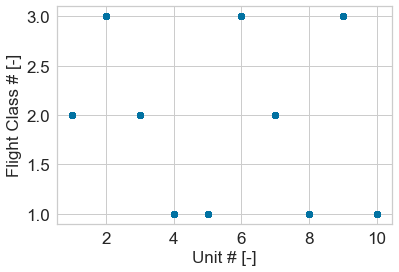

In [12]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [13]:
dic = {}
for i in range(1,len(set(df_A.unit))+1):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 2, 2: 3, 3: 2, 4: 1, 5: 1, 6: 3, 7: 2, 8: 1, 9: 3, 10: 1}

In [14]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,unit,alt,Mach,TRA,T2,C-1,C-2,Segm K-means PCA,Segment,class
0,628.042667,1511.321539,1926.531777,1305.716844,20.030600,14.445617,20.335634,25.652134,433.667246,440.413903,...,1.0,3002.0,0.370377,81.122467,521.900827,10.124057,-2.269444,2,2,2
1,628.030676,1511.266957,1926.545472,1305.729983,20.027941,14.444604,20.332935,25.648438,433.581419,440.325438,...,1.0,3010.0,0.370818,81.122467,521.904702,10.120330,-2.270126,2,2,2
2,628.037901,1511.256216,1926.497756,1305.662340,20.027044,14.444141,20.332025,25.647647,433.541962,440.285902,...,1.0,3017.0,0.371259,81.122467,521.912580,10.118007,-2.271047,2,2,2
3,628.049963,1511.249074,1926.457422,1305.580575,20.025528,14.443352,20.330486,25.646253,433.485825,440.229389,...,1.0,3030.0,0.372078,81.122467,521.926210,10.114420,-2.273128,2,2,2
4,628.053010,1511.208545,1926.360048,1305.474914,20.023754,14.442366,20.328685,25.644478,433.409814,440.153048,...,1.0,3038.0,0.372519,81.122467,521.930527,10.110584,-2.273610,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7219957,566.459593,1258.643737,1497.397109,1137.314974,16.047061,13.748366,16.291432,18.353409,223.357349,227.987269,...,10.0,3018.0,0.258741,26.367001,514.708718,1.558422,4.954317,1,1,1
7219958,566.497803,1258.704446,1497.462049,1137.351624,16.051913,13.752884,16.296358,18.359057,223.412506,228.043709,...,10.0,3013.0,0.259182,26.367001,514.748340,1.562217,4.953874,1,1,1
7219959,566.470161,1258.685975,1497.360571,1137.300341,16.049388,13.749745,16.293795,18.356251,223.405834,228.037402,...,10.0,3009.0,0.258111,26.367001,514.707340,1.561788,4.956026,1,1,1
7219960,566.514360,1258.753800,1497.570601,1137.449455,16.055003,13.755381,16.299496,18.362443,223.464416,228.096246,...,10.0,3006.0,0.258930,26.367001,514.762020,1.566249,4.954389,1,1,1


In [15]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0       3    2196315
1       2     715557
2       1       6247
totale cluster 0 : 2918119
cluster 1
   Classe  Conteggio
0       3     711545
1       1     669204
2       2     596925
totale cluster 1 : 1977674
cluster 2
   Classe  Conteggio
0       3     851164
1       1     807170
2       2     665835
totale cluster 2 : 2324169


In [16]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [17]:
df_segm_pca_kmeans_f = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == 1]
df_W_u = df_segm_pca_kmeans_f[df_segm_pca_kmeans_f.unit == 8]
df_W_u.reset_index(inplace=True, drop=True)
df_W_u
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
#plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name='flight_profile_DS02_clustering.png')
print('min:',df_W_u['alt'].min())
print('max:',df_W_u['alt'].max())

min: 3001.0
max: 16538.0


In [18]:
df_segm_pca_kmeans['cycle'] = df_A['cycle'].values
for i in range(0,3):
    filter_cluster = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == i]
    if filter_cluster['alt'].min() >= 10000:
        print('Saving Cluster',i)
        filename_out = filename.replace('.h5','')
        filename_out += "_clr_" + str(i) + ".csv"
        df_X_s_u_c_mean = filter_cluster.groupby(['unit', 'cycle']).mean()
        df_X_s_u_c_mean = pd.DataFrame(df_X_s_u_c_mean).reset_index()
        df_X_s_u_c_mean.to_csv("./dataset_csv/"+filename_out,index=False)

Saving Cluster 0
